In [ ]:
!pip install itk
!pip install vtk
!pip install SimpleITK
!pip install Pillow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.4/28.4 MB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.8/15.8 MB 69.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 14.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import scipy.ndimage as snd
import pandas as pd
import SimpleITK as sitk
import itk, PIL
from matplotlib import pyplot as plt
from scipy import ndimage, misc, signal, stats
from PIL import Image


In [ ]:
def imTransform(imgA,tPars):
    #input image array and a transformation matrix, return transformed image array
    img = sitk.GetImageFromArray(imgA)
    origin = img.GetOrigin()
    img.SetOrigin((0,0,0))
    transform = sitk.TranslationTransform(2)
    transform.SetParameters(tPars)
    outimage=sitk.Resample(img,img.GetSize(),transform,sitk.sitkLinear,[0,0,0], img.GetSpacing(), img.GetDirection())
    outimage.SetOrigin(origin)
    resultImage = sitk.GetArrayFromImage(outimage)
    return resultImage



In [ ]:
fixedImageReader = itk.ImageFileReader[itk.Image[itk.F, 2]].New()
fixedImageReader.SetFileName("1.tiff")
fixedImageReader.Update()
fixedImage = fixedImageReader.GetOutput()


movingImageReader = itk.ImageFileReader[itk.Image[itk.F, 2]].New()
movingImageReader.SetFileName("2.tiff")
movingImageReader.Update()
movingImage = movingImageReader.GetOutput()


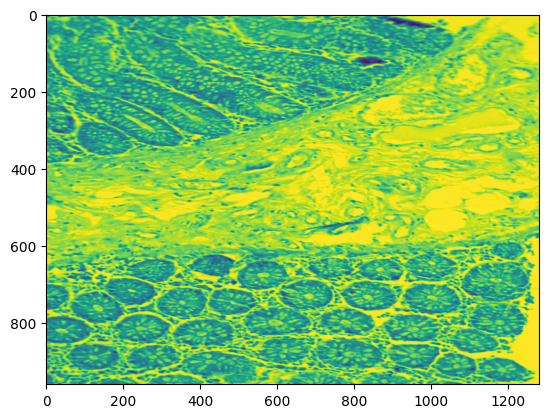

In [ ]:
plt.imshow(movingImage)

(960, 1280)
(960, 1280)
fixed image size    :  itkSize2 ([1280, 960])
fixed image spacing :  itkVectorD2 ([0.264583, 0.264583])
fixed image origin  :  itkPointD2 ([0, 0])
moving image size    :  itkSize2 ([1280, 960])
moving image spacing :  itkVectorD2 ([0.264583, 0.264583])
moving image origin  :  itkPointD2 ([0, 0])


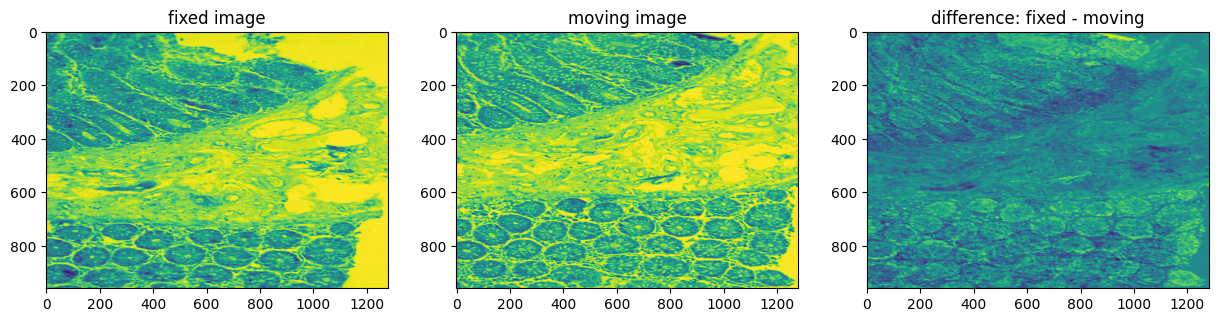

In [ ]:
u  = itk.GetArrayFromImage(fixedImage)
v  = itk.GetArrayFromImage(movingImage)
print(u.shape)
print(v.shape)
f,axs = plt.subplots(1, 3);
f.set_figheight(15)
f.set_figwidth(15)
axs[0].set_title('fixed image')
axs[0].imshow(u)
axs[1].set_title('moving image')
axs[1].imshow(v)
axs[2].set_title('difference: fixed - moving')
axs[2].imshow(u-v)


print("fixed image size    : ", fixedImage.GetLargestPossibleRegion().GetSize())
print("fixed image spacing : ", fixedImage.GetSpacing())
print("fixed image origin  : ", fixedImage.GetOrigin())

print("moving image size    : ", movingImage.GetLargestPossibleRegion().GetSize())
print("moving image spacing : ", movingImage.GetSpacing())
print("moving image origin  : ", movingImage.GetOrigin())


numIterations : 2
stepSize : 15
0 :  119048628.90666667  ,  [-5244211.16759439 -6907120.55896508]
1 :  2848345729.7066665  ,  [-5244211.16759439 -6907120.55896508]


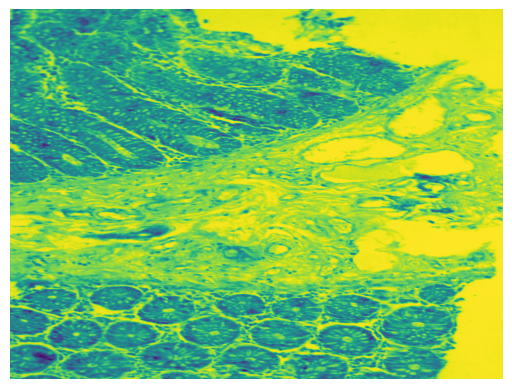

In [ ]:
numIterations = 2
stepSize =  15
def mbNormalize(x):
    nx = ( x - np.mean(x) ) /  np.std(x)
    return nx

#mse
def mseMetric(u,v):
    mbMSE  = 0.0
    n = 1
    for i in range(len(u.shape)):
        n =  n * u.shape[i]
    mbMSE  = np.sum([pow(x-y,2) for x,y in zip(u,v) ]) / float(n)
    #mbSMSE = math.sqrt(mbMSE)
    return mbMSE

def mbImageGradient(F):
    # Sobel kernel
    SbX2D = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
    SbY2D = np.array([[1,2,1 ],[0,0,0 ],[-1,-2,-1]])
    dX = ndimage.convolve(F, SbX2D, mode='constant', cval=0.0)
    dY = ndimage.convolve(F, SbY2D, mode='constant', cval=0.0)
    g = np.dstack((dX,dY))
    return g
# get image gradient using ITK
def imGradient(img):
    f = itk.GetImageFromArray(img)
    df = itk.gradient_image_filter(f)
    g = itk.GetArrayFromImage(df)
    return g

#mse derivative
def mbdMSE(u,v,dT):
    dMSE  = 0.0
    #dM = imGradient(v)
    dM = mbImageGradient(v)
    n = 1
    for i in range(len(u.shape)):
        n =  n * u.shape[i]
    dmse = (2/float(n))* (v-u)
    dMdT = np.array([0.0,0.0])
    for i in range(dM.shape[0]):
        for j in range(dM.shape[1]):
            dx = dM[i,j,0]
            dy = dM[i,j,1]
            dxy0 = np.dot([dx,dy],dT[:,0])
            dxy1 = np.dot([dx,dy],dT[:,1])
            dMdT[0] = dMdT[0] + dmse[i,j]*dxy0
            dMdT[1] = dMdT[1] + dmse[i,j]*dxy1
    dMSE = np.array([dMdT[0], dMdT[1]])
    return dMSE

def gdOptimiser(u,v,numIterations,stepSize):
    nMu = [0,0]
    dT = np.array([[1,0],[0,1]])
    for i in range(numIterations):
        v_t = imTransform(v,nMu)
        tMshow = 0
        if tMshow:
            f = plt.figure();f.set_figheight(15);f.set_figwidth(15)
            f.add_subplot(1,2, 1)
            plt.imshow(v_t)
        mv = mseMetric(u,v_t)
        dMu = mbdMSE(u,v_t,dT)
        nMu = np.array(nMu) - ( stepSize * np.array(dMu ))
        print(i,": ",mv," , ", nMu)
    return nMu

print("numIterations :", numIterations)
print("stepSize :", stepSize)

fMu =  gdOptimiser(u,v,numIterations,stepSize)

r0=imTransform(v,fMu)
f,axs = plt.subplots(1, 4);
f.set_figheight(15);f.set_figwidth(15)
axs[0].set_title('fixed image')
axs[0].imshow(u)
axs[1].set_title('moving image')
axs[1].imshow(v)
axs[2].set_title('difference before: fixed - moving')
axs[2].imshow(u-v)
axs[3].set_title('difference after: fixed - registered')
axs[3].imshow(u-r0)
# plt.imshow()
# plt.axis('off')
# plt.savefig(f'2_reg.tiff', format='tiff', bbox_inches='tight', pad_inches=0)




In [ ]:
import time
for i in range(1,11):
  if i + 1 > 10:
    break
  start_time = time.time()
  fixedImageReader = itk.ImageFileReader[itk.Image[itk.F, 2]].New()
  fixedImageReader.SetFileName(f"{i}.tiff")
  fixedImageReader.Update()
  fixedImage = fixedImageReader.GetOutput()


  movingImageReader = itk.ImageFileReader[itk.Image[itk.F, 2]].New()
  movingImageReader.SetFileName(f"{i+1}.tiff")
  movingImageReader.Update()
  movingImage = movingImageReader.GetOutput()

  u = itk.GetArrayFromImage(fixedImage)
  v = itk.GetArrayFromImage(movingImage)

  fMu =  gdOptimiser(u,v,numIterations,stepSize)

  r0=imTransform(v,fMu)
  print(f"{i} and {i+1} took {time.time() - start_time} sec")
  plt.imshow(u-r0)
  plt.axis('off')

  plt.savefig(f'{i+1}_reg.tiff', format='tiff', bbox_inches='tight', pad_inches=0)
  plt.clf()

0 :  119048628.90666667  ,  [-5244211.16759439 -6907120.55896508]
1 :  2848345729.7066665  ,  [-5244211.16759439 -6907120.55896508]
1 and 2 took 20.409829139709473 sec
0 :  114303412.90666667  ,  [5351566.55845016 -170987.53406996]
1 :  2811663482.88  ,  [5351566.55845016 -170987.53406996]
2 and 3 took 19.163846492767334 sec
0 :  92370534.4  ,  [-10759504.26531268  -4666773.81952756]
1 :  2799193292.8  ,  [-10759504.26531268  -4666773.81952756]
3 and 4 took 21.514310836791992 sec
0 :  149393408.0  ,  [13461839.5440401  56178624.36326104]
1 :  2899856370.346667  ,  [13461839.5440401  56178624.36326104]
4 and 5 took 19.285892248153687 sec
0 :  158408103.25333333  ,  [ -4545882.58299442 -24455075.78897631]
1 :  2744459810.133333  ,  [ -4545882.58299442 -24455075.78897631]
5 and 6 took 20.50905704498291 sec
0 :  161466763.94666666  ,  [-49887254.1349166  -62048877.62883693]
1 :  2540619694.08  ,  [-49887254.1349166  -62048877.62883693]
6 and 7 took 19.052757024765015 sec
0 :  149679950.506

<Figure size 640x480 with 0 Axes>

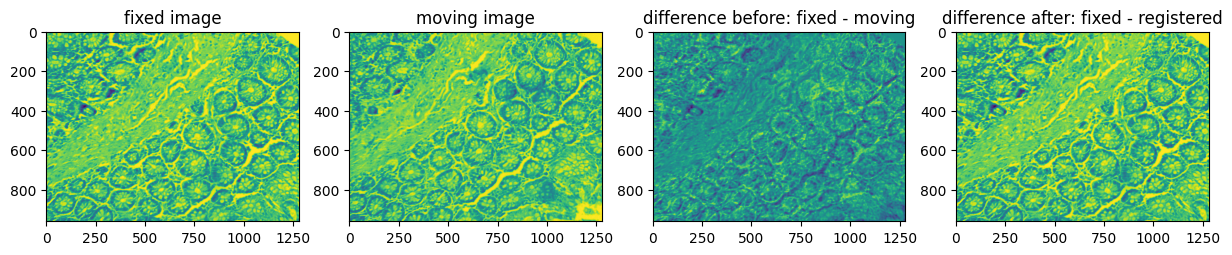

In [ ]:
f,axs = plt.subplots(1, 4);
f.set_figheight(15);f.set_figwidth(15)
axs[0].set_title('fixed image')
axs[0].imshow(u)
axs[1].set_title('moving image')
axs[1].imshow(v)
axs[2].set_title('difference before: fixed - moving')
axs[2].imshow(u-v)
axs[3].set_title('difference after: fixed - registered')
axs[3].imshow(u-r0)
